In [ ]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2024-04-23 05:27:43--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  16.6MB/s    in 11s     

2024-04-23 05:27:54 (15.0 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [ ]:
import tarfile
file_path = "cifar-10-python.tar.gz"

with tarfile.open(file_path, "r:gz") as tar:
    tar.extractall()

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
data1 = unpickle('/content/cifar-10-batches-py/data_batch_1')

In [ ]:
keys = data1.keys()

# Convert the keys view object to a list if needed
keys_list = list(keys)

# Print the keys
print(keys_list)

[b'batch_label', b'labels', b'data', b'filenames']


In [ ]:
import numpy as np
from PIL import Image

data = data1[b"data"][28]
# data
image_data = data.reshape(3,32, 32)
# image_data
dd1 = np.swapaxes(image_data,0,2)
dd1 = np.rot90(dd1,3)
image = Image.fromarray(dd1)
image.save('sample_image.png')

In [ ]:
print(image_data.shape)

(32, 32, 3)


In [1]:
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56441 sha256=e50ac25692b70578ff38c290e83e798dbe6ccbea8e50118321e2cb5ce5cb5b7b
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [3]:
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.metrics import classification_report, confusion_matrix
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')
# from keras.utils.np_utils import to_categorical

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [6]:
len(X_test)

10000

In [7]:
from keras.utils import to_categorical

In [8]:
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255

# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = to_categorical(y_train, n_classes)
Y_test = to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)


Shape before one-hot encoding:  (50000, 1)
Shape after one-hot encoding:  (50000, 10)


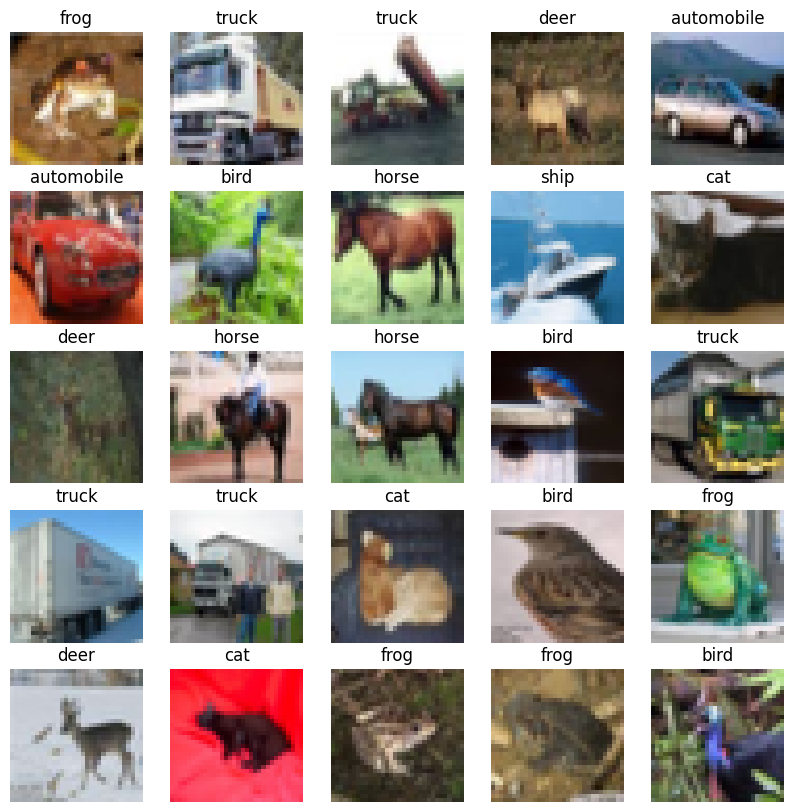

In [9]:
import matplotlib.pyplot as plt
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_train[i])
    plt.title(class_labels[y_train[i][0]])
    plt.axis('off')
plt.show()

In [ ]:
mnet = MobileNetV2(include_top = False, weights = "imagenet" ,input_shape=(32,32,3))

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
from keras.applications import VGG16

# include top should be False to remove the softmax layer
pretrained_model = VGG16(include_top=False, weights='imagenet')
pretrained_model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:
from keras.utils import to_categorical
# extract train and val features
vgg_features_train = pretrained_model.predict(X_train)
vgg_features_val = pretrained_model.predict(X_test)

313/313 [==============================] - 2s 6ms/step


In [ ]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers in the base VGG16 model
for layer in vgg16_base.layers:
    layer.trainable = False

# Create a new model on top of the VGG16 base
model = Sequential()
model.add(vgg16_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train, Y_train, batch_size=128, epochs=100, validation_data=(X_test, Y_test))

# Evaluate the model
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14848586 (56.64 MB)
Trainable params: 133898 (523.04 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1

In [ ]:
model.save('vgg16cds.h5')

In [10]:
model = Sequential()

model.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(32, 32, 3)))

model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(10, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model for 10 epochs
history = model.fit(X_train, Y_train, batch_size=128, epochs=50, validation_data=(X_test, Y_test))

# Evaluate the model
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
391/391 [==============================] - 15s 26ms/step - loss: 1.5722 - accuracy: 0.4243 - val_loss: 1.2018 - val_accuracy: 0.5882
Epoch 2/50
391/391 [==============================] - 9s 24ms/step - loss: 1.0794 - accuracy: 0.6202 - val_loss: 0.9129 - val_accuracy: 0.6772
Epoch 3/50
391/391 [==============================] - 10s 26ms/step - loss: 0.9016 - accuracy: 0.6831 - val_loss: 0.8579 - val_accuracy: 0.7043
Epoch 4/50
391/391 [==============================] - 9s 24ms/step - loss: 0.7889 - accuracy: 0.7241 - val_loss: 0.7573 - val_accuracy: 0.7379
Epoch 5/50
391/391 [==============================] - 9s 24ms/step - loss: 0.7068 - accuracy: 0.7538 - val_loss: 0.7122 - val_accuracy: 0.7538
Epoch 6/50
391/391 [==============================] - 9s 24ms/step - loss: 0.6369 - accuracy: 0.7764 - val_loss: 0.6891 - val_accuracy: 0.7643
Epoch 7/50
391/391 [==============================] - 9s 24ms/step - loss: 0.5843 - accuracy: 0.7932 - val_loss: 0.6583 - val_accuracy: 0.77

In [11]:
model.save('bestmodel.h5')

In [12]:
new_model = tf.keras.models.load_model('bestmodel.h5')

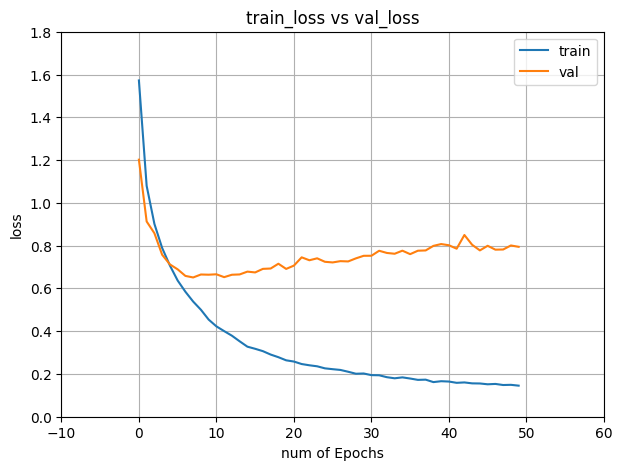

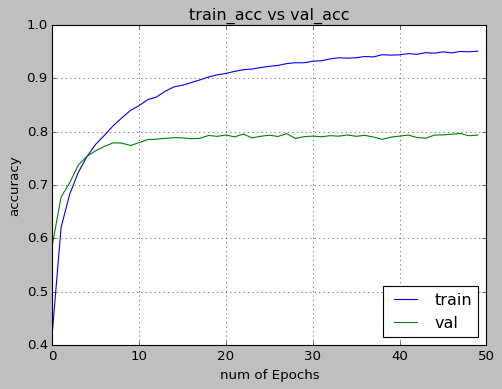

In [14]:
hist = history
epochs = 50
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [13]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 50)        1400      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 75)        33825     
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 75)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 75)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 125)       84500     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 125)         0         
 g2D)                                                   

In [15]:
def predict(img_name,model):
    img = image.load_img(img_name,target_size = (32,32))
    img = image.img_to_array(img)
    plt.imshow(img.astype('int32'))
    plt.show()
    img = preprocess_input(img)
    prediction = model.predict(img.reshape(1,32,32,3))
    output = np.argmax(prediction)
    max_prob = np.max(prediction)
    if max_prob >0.85:
        print(class_labels[output],output,prediction,max_prob)
    else:
        print("Upload Appropriate image")
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.astype('int32'))
    predicted_label=np.argmax(predictions_array)
    true_label=np.argmax(true_label)

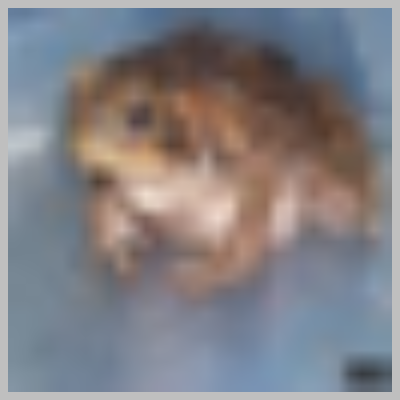

Random image saved as 'random_cifar_image_44536.png'.


In [16]:
import matplotlib.pyplot as plt
import random

# Select a random index
random_index = random.randint(0, len(X_train) - 1)

# Display the image
plt.imshow(X_train[random_index])
plt.axis('off')
plt.show()

# Save the image to a file
image_name = f'random_cifar_image_{random_index}.png'
plt.imsave(image_name, X_train[random_index])

print(f"Random image saved as '{image_name}'.")

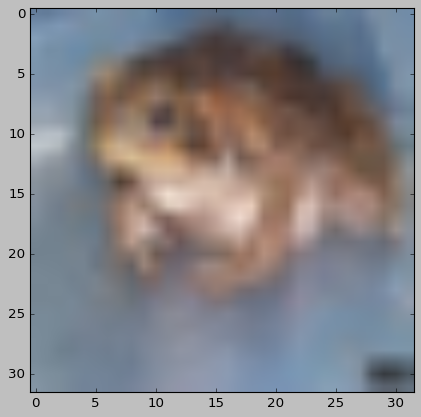

1/1 [==============================] - 1s 796ms/step
frog 6 [[4.47915734e-16 8.44548335e-13 1.62460982e-11 1.82546964e-11
  1.25155545e-17 3.50031643e-15 1.00000000e+00 7.03001254e-21
  6.59768204e-12 7.57306341e-14]] 1.0


In [17]:
predict(("/content/random_cifar_image_44536.png"),model)

313/313 [==============================] - 1s 4ms/step


<Figure size 800x640 with 0 Axes>

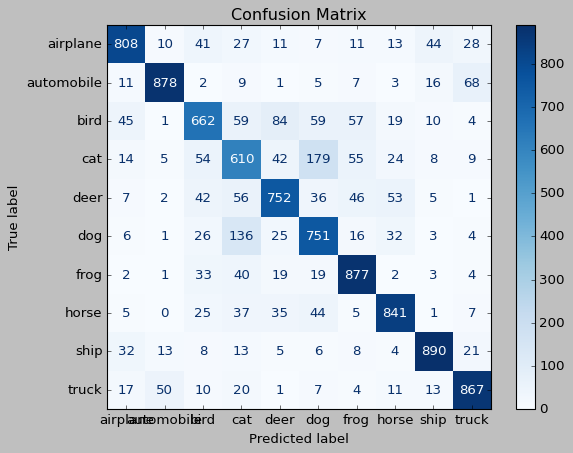

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Perform predictions on the test set
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()